In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import os
from pathlib import Path
path = Path('/kaggle/input/titanic')

In [3]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

# **Cleaning the tabular data**

In [4]:
df = pd.read_csv(path/'train.csv')
df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


.isna() shows if any column in the dataframe is missing values or NaN, e.g., Cabin

.isna().sum() shows the sum along each column

In [5]:
df.isna()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False,False,False,True,False
887,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,True,False,False,False,False,True,False
889,False,False,False,False,False,False,False,False,False,False,False,False


In [6]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

To create a linear NN model, each column element needs to be multiplied by some coefficients, so NaN (missing values) are not permissible.

They need to be replaced by something. Here, the most common value (*mode*) of a selected column is used.

In [7]:
#iloc[0] selects the first row, in case more than one value appears as the most common
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [8]:
#'fillna' replaces the missing values with the mode of each column in the dataframe
df.fillna(modes, inplace=True)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,B96 B98,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,24.0,1,2,W./C. 6607,23.4500,B96 B98,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [9]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

*describe* generates descriptive statistics that summarize the central tendency, dispersion and shape of a dataset's distribution, excluding NaN values

In [10]:
#Description of numerical columns in the DF
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


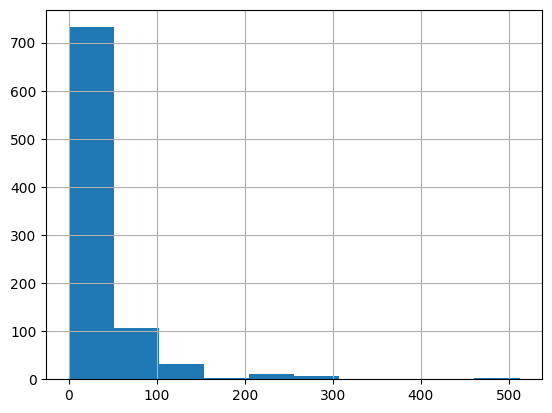

In [11]:
#To present the variation in fare values
#shows a long tail distribution
df['Fare'].hist();

Some models, like a linear model, do not work well with long tail distributions, as once that column is multiplied by a coefficient later, the few rows with really big values will dominate the result. 

log implementation squishes the large values and makes the distribution more reasonable.

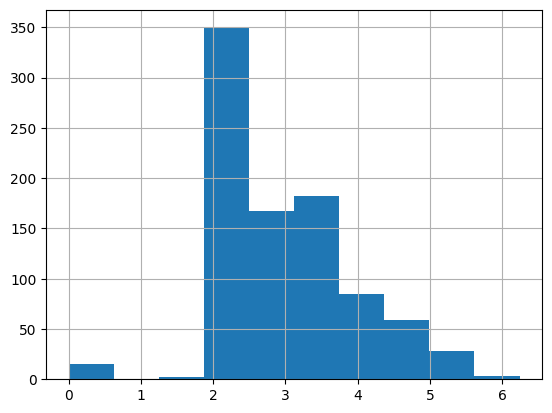

In [12]:
#Using log provides a more even distribution of values
df['LogFare'] = np.log(df['Fare']+1)
df['LogFare'].hist();

In [13]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [14]:
#Description of non numerical variables in the DF
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


The strings (e.g., male, S, etc.) need to be replaced by numerical variables so that they can be multiplied by coefficients. This is done
by creating dummy variables. A dummy variable is a column that contains a 1 where a particular column contains a particular value, or a 0 otherwise. e.g., a column with 0s and 1s, with 'male' corresponding to 1 and 0 otherwise.

*get_dummies* in Pandas creates these and removes the original columns. Dummy variables are generated for "Sex", "Pclass", and "Embarked".
However, "Cabin", "Name", and "Ticket" have too many unique values and so are left out.

In [15]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'LogFare'], dtype='object')

In [16]:
df = pd.get_dummies(df, columns=["Sex", "Pclass", "Embarked"], dtype=int)
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [17]:
df

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,LogFare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,B96 B98,2.110213,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,4.280593,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,2.188856,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,3.990834,1,0,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,B96 B98,2.202765,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,B96 B98,2.639057,0,1,0,1,0,0,0,1
887,888,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,3.433987,1,0,1,0,0,0,0,1
888,889,0,"Johnston, Miss. Catherine Helen ""Carrie""",24.0,1,2,W./C. 6607,23.4500,B96 B98,3.196630,1,0,0,0,1,0,0,1
889,890,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,3.433987,0,1,1,0,0,1,0,0


In [18]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


Creating independent (predictors) and dependent (target) variables.

In [19]:
#Survivors are dependent variables
from torch import tensor

t_dep = tensor(df.Survived)

In [20]:
t_dep.shape

torch.Size([891])

In [21]:
#All the continuous variables of interest and the dummies are the independent variables
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [22]:
t_indep.shape

torch.Size([891, 12])

In [23]:
#Rank of the tensor
len(t_indep.shape)

2

# **Setting up a linear model**

The various steps of a simple linear model are created manually for better understanding (Look back at chapter 4). 

First, determining predictions and loss for every row of the data. A set of random numbers is collected in between (-0.5,0.5) as coefficients for each column in t_indep.

In [24]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
print (n_coeff)
print ()
coeffs = torch.rand(n_coeff)-0.5
coeffs

12



tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [25]:
print (t_indep.shape)
print (coeffs.shape)

torch.Size([891, 12])
torch.Size([12])


In [26]:
#matrix*vector multiplication
t_indep*coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

The first column (Age) has larger values; consequently, the sums of each row will be dominated by the first column, since that's bigger on average than all the others.

To adjust that, each column is divided by its max value (normalizing), so that all the columns contain numbers from 0 to 1 (in the same range).

In [27]:
vals,indices = t_indep.max(dim=0)
print (vals)
print (indices)

tensor([80.0000,  8.0000,  6.0000,  6.2409,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000])
tensor([630, 159, 678, 258,   0,   1,   1,   9,   0,   1,   5,   0])


In [28]:
t_indep = t_indep / vals

In [29]:
t_indep*coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

Using the normalized data, predictions are made from our linear model by adding up the rows of the product:

In [30]:
preds = (t_indep*coeffs).sum(axis=1)
preds[:10]

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

In [31]:
#preds for 891 passengers in the df
preds.shape

torch.Size([891])

Next, the gradient descent protocol is implemented to improve the results. This in turn, requires a loss function, MAE is considered

In [32]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5382)

In [33]:
#Predictions and loss are wriiten into functions
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

# **Gradient Descent**

First, a manual step for a single epoch of gradient descent

In [34]:
#function with an _ at the end defines an in-place operation, i.e, this will change the parameters, here 'coeffs'
coeffs.requires_grad_()

#coeffs are same as early with 'requires_grad'

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [35]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

In [36]:
#Using backward() to ask PyTorch to calculate gradients 

loss.backward()

In [37]:
#The calculated gradient
coeffs.grad

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

In [38]:
#Each time *backward* is called, the gradients are added to whatever is in the .grad attribute
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.0212,  0.0258, -0.0082, -0.0969,  0.4198, -0.4265, -0.2424, -0.0494,  0.2851, -0.3771, -0.0382,  0.4085])

The .grad values are doubled. That's because it added the gradients a second time. Therefore, after using the gradients to do a gradient descent step, they should be set back to zero (torch.no_grad()).

In [39]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()

#The following updates coeffs
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.4945)


a.sub_(b) subtracts b from a in-place; a.zero_() sets all elements of a tensor to zero. 

0.1 is a learning rate taken

The loss goes down!

This concludes one step/epoch

# **Training the linear model**

First splitting the data for training and validation sets

In [40]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

In [41]:
#list of the indices of the rows in the validation set
val_split

(#178) [303,778,531,385,134,476,691,443,386,128,579,65,869,359,202,187,456,880,705,797...]

In [42]:
#Applying those indices to our independent and dependent variables

trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

Creating functions for the previous manual setups

1. Updating coeffs
2. Performing a gradient descent step
3. Initializing coeffs to random numbers

In [43]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [44]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [45]:
#Initial coefficients
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

In [46]:
#Using the functions, a training model is defined. Default epochs=30, lr=0.01
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [47]:
coeffs = train_model(18, lr=0.2)
#Prints the loss after each epoch

0.536; 0.502; 0.477; 0.454; 0.431; 0.409; 0.388; 0.367; 0.349; 0.336; 0.330; 0.326; 0.329; 0.304; 0.314; 0.296; 0.300; 0.289; 

**Coefficients**

Each coefficient represents how much the log-odds of survival (in logistic regression) or the predicted value (in linear regression) change with a one-unit change in the corresponding feature, holding all other features constant.

- **Positive Coefficient**: An increase in the feature value is associated with an increase in the likelihood of survival.
- **Negative Coefficient**: An increase in the feature value is associated with a decrease in the likelihood of survival.
- **Magnitude**: The larger the absolute value of the coefficient, the stronger the effect of that feature on the prediction.

Example

Age :: -0.2694 : Older age is associated with a lower likelihood of survival

Parch :: 0.2359 : Having more parents/children aboard is associated with a higher likelihood of survival

Sex_male :: -0.3990 : Male passengers are associated with a lower likelihood of survival

Sex_female :: 0.2345 : Female passengers are associated with a higher likelihood of survival

Pclass_1 :: 10.7232 : Being in 1st class is strongly associated with a higher likelihood of survival

In [48]:
#The coefficients for each column:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2694),
 'SibSp': tensor(0.0901),
 'Parch': tensor(0.2359),
 'LogFare': tensor(0.0280),
 'Sex_male': tensor(-0.3990),
 'Sex_female': tensor(0.2345),
 'Pclass_1': tensor(0.7232),
 'Pclass_2': tensor(0.4112),
 'Pclass_3': tensor(0.3601),
 'Embarked_C': tensor(0.0955),
 'Embarked_Q': tensor(0.2395),
 'Embarked_S': tensor(0.2122)}

# **Measuring Accuracy**

In [49]:
preds = calc_preds(coeffs, val_indep)

Assuming that any passenger with a score of over 0.5 is predicted to survive. So that means we're correct for each row where preds>0.5 is the same as the dependent variable.

In [50]:
#val_dep.bool() is the actual data in the validation set
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

In [51]:
#True=1
results.float().mean()

tensor(0.7865)

In [52]:
#Creating an accuracy function

def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7865)

# **Using sigmoid**

In [53]:
preds[:28]

tensor([ 0.8160,  0.1295, -0.0148,  0.1831,  0.1520,  0.1350,  0.7279,  0.7754,  0.3222,  0.6740,  0.0753,  0.0389,  0.2216,  0.7631,
         0.0678,  0.3997,  0.3324,  0.8278,  0.1078,  0.7126,  0.1023,  0.3627,  0.9937,  0.8050,  0.1153,  0.1455,  0.8652,  0.3425])

Some predictions are >1 or <0. To correct those, a sigmoid function is introduced

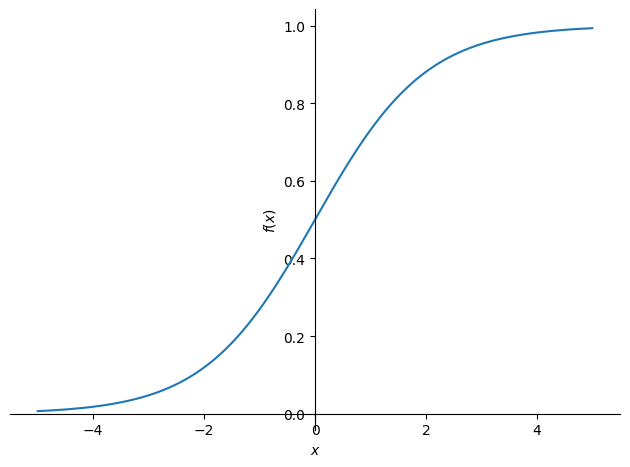

In [54]:
import sympy as sp

x = sp.symbols('x')
expr = 1/(1 + sp.exp(-x))
sp.plot(expr, (x, -5, 5));

In [55]:
#PyTorch already defines that function; calc_preds needs to be modified to use it:

def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [56]:
coeffs = train_model(lr=100)

0.510; 0.327; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [57]:
acc(coeffs)

tensor(0.8258)

In [58]:
show_coeffs()

{'Age': tensor(-1.5061),
 'SibSp': tensor(-1.1575),
 'Parch': tensor(-0.4267),
 'LogFare': tensor(0.2543),
 'Sex_male': tensor(-10.3320),
 'Sex_female': tensor(8.4185),
 'Pclass_1': tensor(3.8389),
 'Pclass_2': tensor(2.1398),
 'Pclass_3': tensor(-6.2331),
 'Embarked_C': tensor(1.4771),
 'Embarked_Q': tensor(2.1168),
 'Embarked_S': tensor(-4.7958)}

In general, older people and males were less likely to survive, and first-class passengers were more likely to survive.

# **Using the model on the test.csv**

In [59]:
#Notice 'Survived' column is missing
tst_df = pd.read_csv(path/'test.csv')
tst_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [60]:
tst_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [61]:
#test set is missing Fare for one passenger; filling 0 to avoid problems
tst_df['Fare'] = tst_df.Fare.fillna(0)

In [62]:
tst_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

In [63]:
#Preprocessing steps as for the training set
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"], dtype=int)

#Normalization steps as for the training set
tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

In [64]:
#Calculating predictions for the test data

tst_df['Survived'] = (calc_preds(tst_indep, coeffs)>0.5).int()

In [65]:
#Creating a csv datafile for the test set
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('Test_survivor.csv', index=False)

In [66]:
!head Test_survivor.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


# Using matrix product

The following steps do not change the outcome, but only simplify a few steps for integrating matrix manipulation in a NN model

In [67]:
#The predictions are determined as
(val_indep*coeffs).sum(axis=1)

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3512, -13.6469,   3.6248,   5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,
          3.9393, -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237, -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,
         -2.7433, -12.3210, -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,  -3.2275, -12.0289,  13.4560, -21.7230,
         -3.1366, -13.2462, -21.7230, -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,  -2.9386,  -5.3103, -22.2384,
        -22.1097, -21.7466, -13.3780, -13.4909, -14.8119, -22.0690, -21.6666, -21.7818,  -5.4439, -21.7407, -12.6551, -21.6671,   4.9238,
        -11.5777, -13.3323, -21.9638, -15.3030,   5.0243, -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230, -11.9652,
        -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,   4.9207,  -7.3198,  -5.3081,   7.1065,  11.4948, -13.3135, -21.8723,
        -21.7230,  13.3603, -15.56

In [68]:
#The step is simplified in PyTorch tensors using @ to indicate matrix products
val_indep@coeffs

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3511, -13.6468,   3.6248,   5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,
          3.9393, -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237, -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,
         -2.7433, -12.3210, -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,  -3.2275, -12.0289,  13.4560, -21.7230,
         -3.1366, -13.2462, -21.7230, -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,  -2.9386,  -5.3103, -22.2384,
        -22.1097, -21.7466, -13.3780, -13.4909, -14.8119, -22.0690, -21.6666, -21.7818,  -5.4439, -21.7407, -12.6551, -21.6671,   4.9238,
        -11.5777, -13.3323, -21.9638, -15.3030,   5.0243, -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230, -11.9652,
        -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,   4.9207,  -7.3198,  -5.3081,   7.1065,  11.4948, -13.3135, -21.8723,
        -21.7230,  13.3603, -15.56

In [69]:
# Redefining calc_preds

def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

An NN model (at a later step) would require a number of coefficients, for which the variable *coeffs* is changed from a column vector to a matrix with a single column. 

The overall *indeps@coeffs* would be a matrix*matrix multiplication

In [70]:
# Redefining Initial coefficients
# The second argument 1 to torch.rand() indicates that the coefficients should have one column

def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

The dependent variable would also be converted into a column vector

In [71]:
# 'None' tells pytorch to add a new dimension in this position

trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

In [72]:
trn_dep[:10]

tensor([[1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1]])

In [73]:
#Identical outputs are generated from our model

coeffs = train_model(lr=100)

0.512; 0.323; 0.290; 0.205; 0.200; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [74]:
acc(coeffs)

tensor(0.8258)

In [75]:
coeffs

tensor([[ -1.1308],
        [ -1.1755],
        [ -0.6080],
        [  0.4522],
        [-10.1322],
        [  8.6472],
        [  3.4198],
        [  1.8521],
        [ -6.5410],
        [  1.5472],
        [  1.9993],
        [ -4.9103]], requires_grad=True)

# **A neural network**

First, coefficients need to be created for each of the (two) NN layers. The first set of coefficients will take the n_coeff inputs and create n_hidden outputs. A higher n_hidden gives the network more flexibility, but makes it slower and harder to train. 

A matrix of size (n_coeff, n_hidden) is needed. These coefficients are divided by n_hidden so that when they are summed up in the next layer, it'll end up with magnitude numbers to what it started with.

Then the second layer will need to take the n_hidden inputs and create a single output, so that means a (n_hidden, 1) matrix is needed there. The second layer will also need a constant term added.

In [76]:
#layer1 creates coefficients from input (n_coeff) to hidden (20)
#layer2 creates coefficients from hidden to single output
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

**Creating the neural net**

The key steps are the two matrix products, indeps@l1 and res@l2 (where res is the output of the first layer). The first layer output is passed to F.relu (that's the non-linearity), and the second is passed to torch.sigmoid as before.

In [77]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [78]:
#more than one set of coefficients is defined, next, a loop is added to update each one

def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [79]:
#Training the model

coeffs = train_model(lr=1.4)

0.543; 0.532; 0.520; 0.505; 0.487; 0.466; 0.439; 0.407; 0.373; 0.343; 0.319; 0.301; 0.286; 0.274; 0.264; 0.256; 0.250; 0.245; 0.240; 0.237; 0.234; 0.231; 0.229; 0.227; 0.226; 0.224; 0.223; 0.222; 0.221; 0.220; 

In [80]:
coeffs = train_model(lr=20)

0.543; 0.400; 0.260; 0.390; 0.221; 0.211; 0.197; 0.195; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 

In [81]:
acc(coeffs)

tensor(0.8258)

In this case, the neural net isn't showing better results than the linear model. That's not surprising; this dataset is very small and very simple, and isn't the kind of thing that is expected to see neural networks excel at. Furthermore, the validation set is too small to reliably see much accuracy difference. But the key thing is to know exactly what a real neural net looks like

# **Deep Learning**

A deep learning model would require more than one hidden layer with more matrix multiplication steps

First, additional coefficients should be created for each layer

In [82]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want; 2 hidden layers with 10 activations in each
    sizes = [n_coeff] + hiddens + [1] #First matrix from n_coeff to 10, second from 10 to 10, and third from 10 to 1
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

A break down of steps

In [83]:
hiddens = [10, 10]  
hiddens

[10, 10]

In [84]:
sizes = [n_coeff] + hiddens + [1] #First matrix from n_coeff(12) to 10, second from 10 to 10, and third from 10 to 1
sizes

[12, 10, 10, 1]

In [85]:
n = len(sizes)
n

4

In [86]:
layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
layers
#Notice first tensor is (12*10), second is (10*10), and third is (10*1)

[tensor([[-0.0685,  0.2426, -0.1043,  0.0533,  0.1500,  0.1536,  0.1492,  0.1182, -0.1168,  0.0637],
         [-0.0255,  0.2642,  0.2118,  0.1957,  0.2773, -0.0710,  0.2311,  0.0271,  0.0988,  0.1142],
         [ 0.1665, -0.0186, -0.1042,  0.2017,  0.2416,  0.0691, -0.1193,  0.0703,  0.2274,  0.0700],
         [ 0.2566, -0.0206,  0.2244, -0.0731, -0.0640, -0.0964, -0.0475,  0.1735,  0.2540,  0.0470],
         [-0.0217,  0.2591,  0.1502,  0.0102,  0.0380,  0.0990, -0.0107, -0.0782,  0.0202,  0.2351],
         [-0.1076,  0.1800,  0.0171, -0.0406,  0.0467,  0.1412,  0.0260, -0.0600,  0.1383,  0.1068],
         [-0.0934, -0.0971,  0.1067,  0.0533, -0.0486, -0.0513,  0.2125,  0.2588, -0.0882, -0.0181],
         [ 0.0284,  0.1302,  0.2407,  0.2606, -0.0419,  0.1625, -0.0413, -0.0247,  0.2374, -0.0759],
         [ 0.0263,  0.0653,  0.2536,  0.1766,  0.1567,  0.0611,  0.0334,  0.0085,  0.1101, -0.1192],
         [ 0.1532,  0.1689,  0.2031, -0.0874,  0.0709,  0.1456,  0.1401, -0.0423,  0.2354, 

In [87]:
consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
consts

[tensor(0.0204), tensor(0.0491), tensor(0.0097)]

In [88]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

In [89]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [90]:
coeffs = train_model(lr=4)

0.521; 0.483; 0.427; 0.379; 0.379; 0.379; 0.379; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.377; 0.376; 0.371; 0.333; 0.239; 0.224; 0.208; 0.204; 0.203; 0.203; 0.207; 0.197; 0.196; 0.195; 

In [91]:
acc(coeffs)

tensor(0.8258)